In [2]:
!pip install MDAnalysis
!pip install lipyphilic
!pip install hmmlearn

In [1]:
import pathlib
import pickle  # this library is used for saving the analysis objects to file
import joblib
import os

import numpy as np
import MDAnalysis as mda
import lipyphilic as lpp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.mixture
import hmmlearn.hmm
import matplotlib
import plotly.graph_objects as go



/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read the CSV file with space separation and multiple spaces treated as one separator
new_df = pd.read_csv('./linear_density-OK.csv')

# If you need to clean up column names (remove extra spaces)
new_df.columns = new_df.columns.str.strip()

print(new_df.head())

         bin  DPPC         W  CHOL  Tail  Gli  Fosf  ZNPC  Lipid  DPPC_smooth  \
0 -67.641555   0.0  0.963729   0.0   0.0  0.0   0.0   0.0    0.0          NaN   
1 -67.141555   0.0  0.959132   0.0   0.0  0.0   0.0   0.0    0.0          NaN   
2 -66.641555   0.0  0.959044   0.0   0.0  0.0   0.0   0.0    0.0          NaN   
3 -66.141555   0.0  0.958560   0.0   0.0  0.0   0.0   0.0    0.0          NaN   
4 -65.641555   0.0  0.958303   0.0   0.0  0.0   0.0   0.0    0.0          0.0   

   W_smooth  CHOL_smooth  Tail_smooth  Gli_smooth  Fosf_smooth  ZNPC_smooth  \
0       NaN          NaN          NaN         NaN          NaN          NaN   
1       NaN          NaN          NaN         NaN          NaN          NaN   
2       NaN          NaN          NaN         NaN          NaN          NaN   
3       NaN          NaN          NaN         NaN          NaN          NaN   
4  0.959754          0.0          0.0         0.0          0.0          0.0   

   Lipid_smooth  
0           NaN  
1 

# Densidad

In [4]:
## Hago un suavizado de los valores de densidad para que el grafico quede mejor:
# Apply rolling average with window size of 5 (change size as needed)
new_df['Lipid_smooth'] = new_df['Lipid'].rolling(window=5).mean()
new_df['DPPC_smooth'] = new_df['DPPC'].rolling(window=5).mean()
new_df['W_smooth'] = new_df['W'].rolling(window=5).mean()
new_df['CHOL_smooth'] = new_df['CHOL'].rolling(window=5).mean()
new_df['Tail_smooth'] = new_df['Tail'].rolling(window=5).mean()
new_df['Gli_smooth'] = new_df['Gli'].rolling(window=5).mean()
new_df['Fosf_smooth'] = new_df['Fosf'].rolling(window=5).mean()
new_df['ZNPC_smooth'] = new_df['ZNPC'].rolling(window=5).mean()
new_df['Tail_smooth'] = new_df['Tail'].rolling(window=5).mean()

In [5]:
# ## Hago el grafdico de la densidad con Plotly para ver si quedo centrado o no:
## Si cambia edito el valor del Offset para corregir

# Create the plot
fig = go.Figure()

Offset= -0.85

# Add traces for each smoothed line with shading
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['DPPC_smooth'],
                         mode='lines', name='DPPC', line=dict(color='green')))
fig.add_trace(go.Scatter(x=new_df['bin']  - Offset, y=new_df['W_smooth'],
                         mode='lines', name='W', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=new_df['bin']  - Offset, y=new_df['CHOL_smooth'],
                         mode='lines', name='CHOL', line=dict(color='red')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['Gli_smooth'],
                         mode='lines', name='Glicerol', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['Fosf_smooth'],
                         mode='lines', name='Fosfate', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['Tail_smooth'],
                         mode='lines', name='Lipid tail', line=dict(color='black')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 5,
                         mode='lines', name='ZNPC', line=dict(color='lightblue')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['Lipid_smooth'],
                         mode='lines', name='Lipids', line=dict(color='lightblue')))

# Customize the layout
fig.update_layout(
    title='Linear Density Profile with Moving Average Smoothing',
    xaxis_title='z(Å)',
    yaxis_title='Density (g/mL)',
    legend_title='Components',
    template='plotly_white',
    width=800,
    height=600
)

# Show the plot
fig.show()


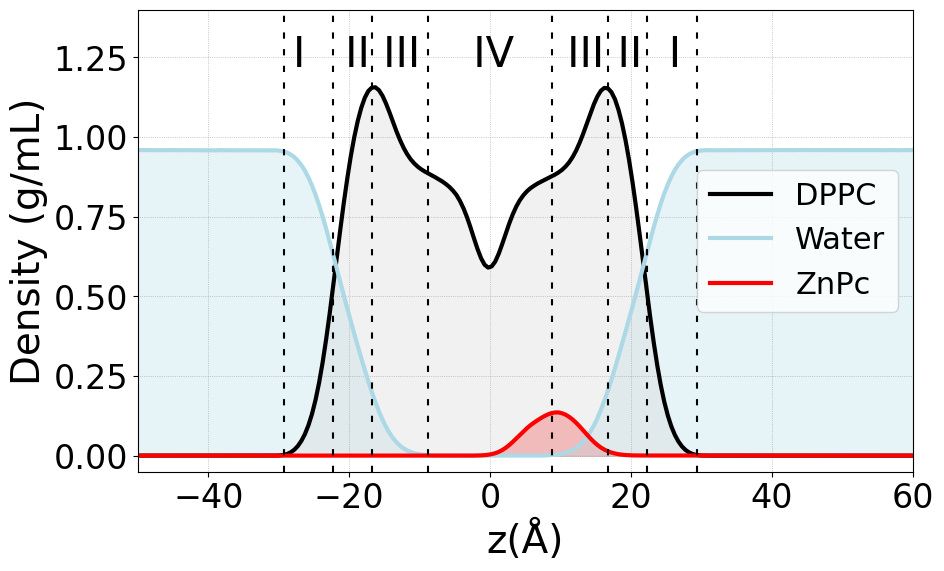

In [6]:

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the smoothed lines with shading
sns.lineplot(x=new_df['bin'] - Offset , y='Lipid_smooth', data=new_df, label='DPPC', color='black',  linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='W_smooth', data=new_df, label='Water', color='lightblue', linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='CHOL_smooth', data=new_df, label='CHOL', color=CHOL_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Gli_smooth', data=new_df, label='Glicerol', color=SAPE_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Tail_smooth', data=new_df, label='Lipid tails', color=SAPI_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Fosf_smooth', data=new_df, label='Fosfates', color='black', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 5, data=new_df, label='ZnPc', linewidth=3.0, color='red')

# Fill the area under ZNPC_smooth curve
plt.fill_between(new_df['bin'] - Offset, new_df['ZNPC_smooth'] * 5, color='red', alpha=0.3)
# Fill the area under ZNPC_smooth curve
plt.fill_between(new_df['bin'] - Offset, new_df['W_smooth'], color='lightblue', alpha=0.3)
plt.fill_between(new_df['bin'] - Offset, new_df['Lipid_smooth'], color='lightgray', alpha=0.3)


# Add a dotted line at the maximum of Gli_smooth series
max_gli_y = new_df['Gli_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_gli_x = new_df['bin'][new_df['Gli_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_gli_x_2 = max_gli_x * (-1)

max_tail_y = new_df['Tail_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_tail_x = new_df['bin'][new_df['Tail_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_tail_x_2 = max_tail_x * (-1)


# Set tolerance values to make np.isclose less strict
tolerance_rtol = 1e-2  # Relative tolerance, can be adjusted as needed
tolerance_atol = 1e-1  # Absolute tolerance, can be adjusted as needed

# Find the points where W_smooth and DPPC_smooth are approximately equal
equal_point = new_df[np.isclose(new_df['W_smooth'], new_df['Lipid_smooth'], rtol=tolerance_rtol, atol=tolerance_atol)]
if not equal_point.empty:
    equal_x = equal_point['bin'].iloc[0] - Offset
    equal_x_2 = equal_x * (-1)
    plt.axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    plt.axvline(x=equal_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)


# Find the point where DPPC_smooth is higher than 0.1 and plot a vertical line
dppc_point = new_df[new_df['Lipid_smooth'] > 0.001]
if not dppc_point.empty:
    dppc_x = dppc_point['bin'].iloc[0] - Offset
    dppc_x_2 = dppc_x * (-1)
    plt.axvline(x=dppc_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    plt.axvline(x=dppc_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)

plt.axvline(x=max_gli_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_gli_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_tail_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_tail_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)



# Add labels and title
plt.xlabel('z(Å)',fontsize=28)
plt.ylabel('Density (g/mL)',fontsize=28)
#plt.title('Linear Density Profile ',fontsize=28)

# Add legend
plt.legend(fontsize=24)
plt.xlim(-50, 60)
plt.ylim(-0.05, 1.40)
plt.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.7)

plt.text(
    -28, 1.22,  # x, y coordinates of the text in data units
    'I   II III    IV    III II  I',  # The text to display
    fontsize=30,  # Font size of the text
    bbox=dict(facecolor='white', alpha=0.0,edgecolor='white' )  # Text box style
)

# Add legend
plt.legend(fontsize=22)

# Show the plot
plt.show()


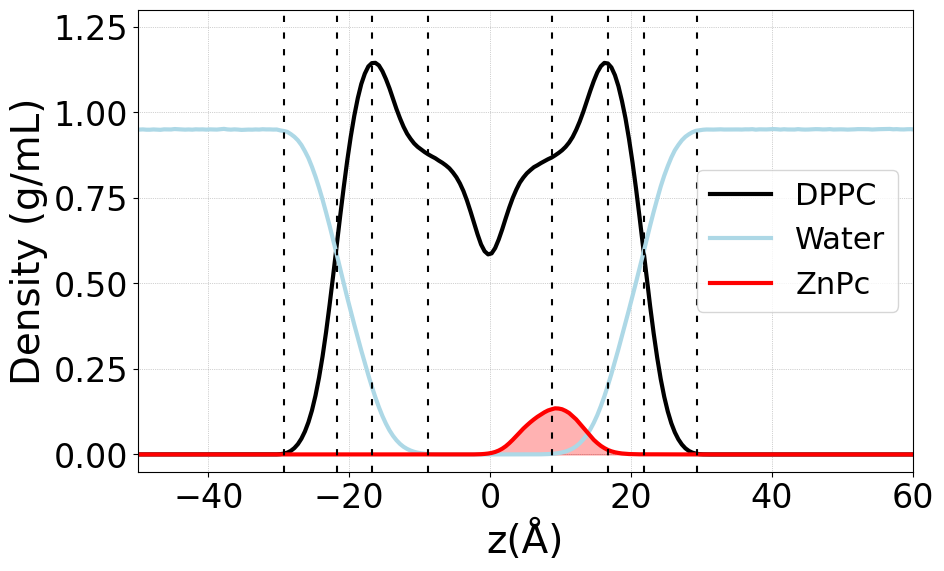

In [ ]:

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the smoothed lines with shading
sns.lineplot(x=new_df['bin'] - Offset , y='Lipid_smooth', data=new_df, label='DPPC', color='black',  linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='W_smooth', data=new_df, label='Water', color='lightblue', linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='CHOL_smooth', data=new_df, label='CHOL', color=CHOL_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Gli_smooth', data=new_df, label='Glicerol', color=SAPE_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Tail_smooth', data=new_df, label='Lipid tails', color=SAPI_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Fosf_smooth', data=new_df, label='Fosfates', color='black', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 5, data=new_df, label='ZnPc', linewidth=3.0, color='red')

# Fill the area under ZNPC_smooth curve
plt.fill_between(new_df['bin'] - Offset, new_df['ZNPC_smooth'] * 5, color='red', alpha=0.3)



# Add a dotted line at the maximum of Gli_smooth series
max_gli_y = new_df['Gli_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_gli_x = new_df['bin'][new_df['Gli_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_gli_x_2 = max_gli_x * (-1)

max_tail_y = new_df['Tail_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_tail_x = new_df['bin'][new_df['Tail_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_tail_x_2 = max_tail_x * (-1)


# Set tolerance values to make np.isclose less strict
tolerance_rtol = 1e-2  # Relative tolerance, can be adjusted as needed
tolerance_atol = 1e-1  # Absolute tolerance, can be adjusted as needed

# Find the points where W_smooth and DPPC_smooth are approximately equal
equal_point = new_df[np.isclose(new_df['W_smooth'], new_df['Lipid_smooth'], rtol=tolerance_rtol, atol=tolerance_atol)]
if not equal_point.empty:
    equal_x = equal_point['bin'].iloc[0] - Offset
    equal_x_2 = equal_x * (-1)
    plt.axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    plt.axvline(x=equal_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)


# Find the point where DPPC_smooth is higher than 0.1 and plot a vertical line
dppc_point = new_df[new_df['Lipid_smooth'] > 0.001]
if not dppc_point.empty:
    dppc_x = dppc_point['bin'].iloc[0] - Offset
    dppc_x_2 = dppc_x * (-1)
    plt.axvline(x=dppc_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    plt.axvline(x=dppc_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)

plt.axvline(x=max_gli_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_gli_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_tail_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_tail_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)



# Add labels and title
plt.xlabel('z(Å)',fontsize=28)
plt.ylabel('Density (g/mL)',fontsize=28)
#plt.title('Linear Density Profile ',fontsize=28)

# Add legend
plt.legend(fontsize=24)
plt.xlim(-50, 60)
plt.ylim(-0.05, 1.30)
plt.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.7)



# Add legend
plt.legend(fontsize=22)

# Show the plot
plt.show()


In [7]:
# Los valores de referencia para los limites de las Regiones son:
print(dppc_x_2)
print(equal_x_2)
print(max_gli_x_2)
print(max_tail_x_2)

print(max_tail_x)
print(max_gli_x)
print(equal_x)
print(dppc_x)


29.291554715718558
22.291554715718558
-16.708445284281446
8.791554715718556
-8.791554715718556
16.708445284281446
-22.291554715718558
-29.291554715718558


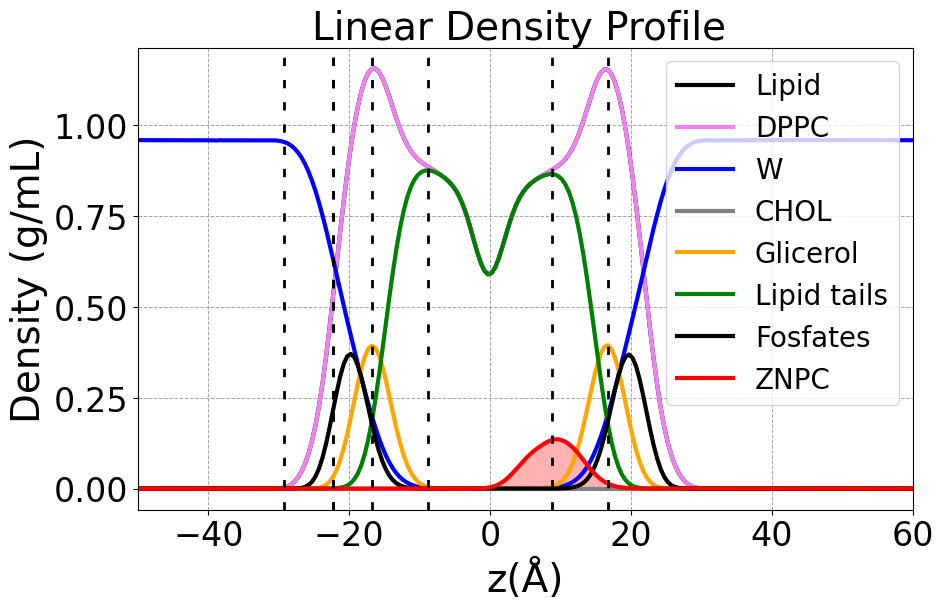

In [8]:
# En este grafico estan graficadas todas las densidades, es solo informativo, no es para version final:


# Create the plot
plt.figure(figsize=(10, 6))

# Plot the smoothed lines with shading
sns.lineplot(x=new_df['bin'] - Offset , y='Lipid_smooth', data=new_df, label='Lipid', color='black',  linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset , y='DPPC_smooth', data=new_df, label='DPPC', color='violet',  linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='W_smooth', data=new_df, label='W', color='blue', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='CHOL_smooth', data=new_df, label='CHOL', color='gray', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='Gli_smooth', data=new_df, label='Glicerol', color='orange', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='Tail_smooth', data=new_df, label='Lipid tails', color='green', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='Fosf_smooth', data=new_df, label='Fosfates', color='black', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 5, data=new_df, label='ZNPC', linewidth=3.0, color='red')

# Add labels and title
plt.xlabel('z(Å)',fontsize=28)
plt.ylabel('Density (g/mL)',fontsize=28)
plt.title('Linear Density Profile ',fontsize=28)

# Add legend
plt.legend(fontsize=24)
plt.xlim(-50, 60)
plt.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)



# Fill the area under ZNPC_smooth curve
plt.fill_between(new_df['bin'] - Offset, new_df['ZNPC_smooth'] * 5, color='red', alpha=0.3)

# Add a dotted line at the maximum of Gli_smooth series
max_gli_y = new_df['Gli_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_gli_x = new_df['bin'][new_df['Gli_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_gli_x_2 = max_gli_x * (-1)

max_tail_y = new_df['Tail_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_tail_x = new_df['bin'][new_df['Tail_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_tail_x_2 = max_tail_x * (-1)


# Set tolerance values to make np.isclose less strict
tolerance_rtol = 1e-2  # Relative tolerance, can be adjusted as needed
tolerance_atol = 1e-1  # Absolute tolerance, can be adjusted as needed

# Find the points where W_smooth and DPPC_smooth are approximately equal
equal_point = new_df[np.isclose(new_df['W_smooth'], new_df['DPPC_smooth'], rtol=tolerance_rtol, atol=tolerance_atol)]
if not equal_point.empty:
    equal_x = equal_point['bin'].iloc[0] - Offset
    equal_x_2 = equal_x * (-1)
    plt.axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label=None)
    plt.axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label=None)


# Find the point where DPPC_smooth is higher than 0.1 and plot a vertical line
dppc_point = new_df[new_df['DPPC_smooth'] > 0.001]
if not dppc_point.empty:
    dppc_x = dppc_point['bin'].iloc[0] - Offset
    plt.axvline(x=dppc_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)

plt.axvline(x=max_gli_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
plt.axvline(x=max_gli_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
plt.axvline(x=max_tail_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label=None)
plt.axvline(x=max_tail_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label=None)


# Add legend
plt.legend(fontsize=20)

# Show the plot
plt.show()


In [ ]:
# Define the file path
#file_path = r'linear_density-OK.csv'

# Get the directory path and ensure it exists
#directory_path = os.path.abspath(os.path.dirname(file_path))
#os.makedirs(directory_path, exist_ok=True)

# Save the DataFrame to the CSV file
#new_df.to_csv(file_path, index=False)  # Set index=False to exclude the index column in the CSV file
